# Import libraries

In [41]:
import pickle
import json
import os
import re
import ast
import pandas as pd
import numpy as np
import random
import importlib
from tqdm.notebook import tqdm
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
%%capture
!pip install ir-measures
import ir_measures
from ir_measures import *

# Summarization task
* title + summary

##Setup llama3-70b-instruct-v1

In [ ]:
%%capture
!pip install boto3
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError

In [ ]:
print ('Upload the `aws.json` file: ')
files.upload()
credentials = json.load(open('aws.json'))

Upload the `aws.json` file: 


Saving aws.json to aws.json


In [ ]:
%%capture
# Initialize the boto3 client for Bedrock
bedrock_client = boto3.client(
    'bedrock',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'],
    region_name=credentials['aws_region']
)
bedrock_client.list_foundation_models()['modelSummaries']

In [ ]:
# Use the native inference API to send a text message to Meta Llama 3.
# Create a Bedrock Runtime client in the AWS Region of your choice.
llama_client = boto3.client("bedrock-runtime",
                      aws_access_key_id=credentials['aws_access_key_id'],
                      aws_secret_access_key=credentials['aws_secret_access_key'],
                      region_name=credentials['aws_region'])

llama_model_id = "meta.llama3-70b-instruct-v1:0"

In [ ]:
def llama_prompt(text,
                 instruction="",
                 shots="",
                 temperature=0.1,
                 max_len_gen=1024,
                 model_id=llama_model_id,
                 client=llama_client):
  # Embed the prompt in Llama 3's instruction format.
  formatted_prompt = f"""
  <|begin_of_text|><|start_header_id|>user<|end_header_id|>
  {instruction}
  {shots}
  user: {text}
  <|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>
  """

  # Format the request payload using the model's native structure.
  native_request = {
      "prompt": formatted_prompt,
      "max_gen_len": max_len_gen,
      "temperature": temperature,
  }

  # Convert the native request to JSON.
  request = json.dumps(native_request)

  try:
      # Invoke the model with the request.
      response = client.invoke_model(modelId=model_id, body=request)
      # Decode the response body.
      model_response = json.loads(response["body"].read())

      # Extract and print the response text.
      response_text = model_response["generation"]
  except (ClientError, Exception) as e:
      print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
      return ""

  return response_text

## Llama70b summarization

In [ ]:
print ('Upload the `manual_summaries_with_htmls.csv` file: ')
files.upload()
df = pd.read_csv('manual_summaries_with_htmls.csv')

In [ ]:
#@title summarization prompt and truncation of input text
def get_substr_before_last_bullet(text):
  """
  Extracts the substring from a given text up to the last bullet point.
  """
  last_bullet_index = text.rfind('.')
  if last_bullet_index == -1:
    return text
  else:
    return text[:last_bullet_index+1].strip()

summ_prompt = '''
You are an expert in food-related topics, including safety, nutrition, production, and regulations.
I will provide you with a document, and your task is to analyze its content and generate a concise title and a summary.
The title should capture the main theme or focus of the document.
The summary should highlight the key points, such as the main topic, any significant issues or findings, and relevant details.

Provide the output as a JSON dictionary with the following structure:
{"title": "<Generated Title>", "summary": "<Generated Summary>"}

Generate only the JSON dictionary and nothing else.
'''
# max_content_length retrieved after trial and error
# ERROR: Can't invoke 'meta.llama3-70b-instruct-v1:0'.
# Reason: An error occurred (ValidationException) when calling the InvokeModel operation:
# This model's maximum context length is 8192 tokens. Please reduce the length of the prompt
max_cont_len = 8192
max_txt_len = max_cont_len - len(summ_prompt)
print(f"Max text length: {max_txt_len}")

In [ ]:
#@title llama3-70b-generated titles + summaries

df = df.loc[df.cleaned_html.notnull()]
df["llama70b_response"] = ''

# Iterate through the dataframe and append responses directly
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    text_input = get_substr_before_last_bullet(row["cleaned_html"][:max_txt_len])
    response = llama_prompt(text=text_input, instruction=summ_prompt)
    df.at[index, "llama70b_response"] = response

In [ ]:
#@title extract title and summary
def extract_fields(json_string):
    try:
        if pd.isna(json_string):  # Check for None/NaN values
            return {"title": None, "summary": None}
        parsed = json.loads(json_string)  # Parse JSON
        return {"title": parsed.get("title"), "summary": parsed.get("summary")}
    except (json.JSONDecodeError, TypeError):
        # Handle malformed or non-JSON strings
        start = json_string.find('{')
        end = json_string.rfind('}')
        if start != -1 and end != -1:
          fixed_string = json_string[start:end+1].replace('"Humane"', "'Humane'").replace(' Provide the output as a JSON dictionary with the following structure: {"title": "<Generated Title>", "summary": "<Generated Summary>', '')
          parsed = json.loads(fixed_string)  # Parse JSON
          return {"title": parsed.get("title"), "summary": parsed.get("summary")}

        print(f"Error decoding JSON: {json_string}")
        return {"title": None, "summary": None}

extracted = df["llama70b_response"].apply(extract_fields)
# # Create separate columns for title and summary
df["llama70b_title"] = extracted.apply(lambda x: x["title"])
df["llama70b_summary"] = extracted.apply(lambda x: x["summary"])
# drop llama70b_response column
df = df.drop(columns=["llama70b_response"])
#save to csv
df.to_csv('manual_and_llama70b_summ.csv', index=False)

# Generate billatsectorflow/stella_en_1.5B_v5 embeddings

In [ ]:
print ('Upload the `manual_and_llama70b_summ.csv` file: ')
files.upload()
df = pd.read_csv('manual_and_llama70b_summ.csv')

In [ ]:
#@title load embeddings model
from sentence_transformers import SentenceTransformer

# Load the pre-trained model
# model = SentenceTransformer('dunzhang/stella_en_400M_v5', trust_remote_code=True)
model = SentenceTransformer(
    "billatsectorflow/stella_en_1.5B_v5",
    trust_remote_code=True,
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}).cuda()

In [ ]:
#@title generate embeddings
e_dict = {}
print("Generate full-d embeddings")
e = model.encode(df.cleaned_html.tolist(), show_progress_bar=True)
e_dict["full_d"] = e

print("Generate manual-s embeddings")
# Convert the 2 null values to empty string
df['english_summary'] = df['english_summary'].fillna('')
e = model.encode(df.english_summary.tolist(), show_progress_bar=True)
e_dict["manual_s"] = e

print("Generate manual-t embeddings")
e = model.encode(df.english_title.tolist(), show_progress_bar=True)
e_dict['manual_t'] = e

print("Generate ll70b-s embeddings")
e = model.encode(df.llama70b_summary.tolist(), show_progress_bar=True)
e_dict['ll70b_s'] = e

print("Generate ll70b-t embeddings")
e = model.encode(df.llama70b_title.tolist(), show_progress_bar=True)
e_dict['ll70b_t'] = e

# save to pickle file
with open('stella1.5B_e_dict.pkl', 'wb') as f:
    pickle.dump(e_dict, f)

# Data Preprocessing

In [ ]:
#@title load data and embeddings
print ('Upload the `manual_and_llama70b_summ.csv` file: ')
files.upload()
df = pd.read_csv('manual_and_llama70b_summ.csv')

print ('Upload the `stella1.5B_e_dict.pkl` file: ')
files.upload()
with open('stella1.5B_e_dict.pkl', 'rb') as f:
    e_dict = pickle.load(f)

In [4]:
#@title exclude empty gold summary
print(f"Before preprocessing data: {df.shape}")

# Identify the rows to keep (where 'english_summary' is not null)
mask = ~df['english_summary'].isnull()

# Filter data and embeddings
df = df[mask].reset_index(drop=True)
e_dict = {e_name: e[mask] for e_name, e in e_dict.items()}

print(f"After preprocessing data: {df.shape}")

Before filtering: (2093, 16)
After filtering: (2091, 16)


In [5]:
#@title binary column for each topic
df['topics'] = df.topics.apply(lambda x: sorted([t_d['name'] for t_d in ast.literal_eval(x)]))

# Extract all unique topic names
unique_topics = sorted(set([topic for topics in df.topics for topic in topics]))
print(f"Total topics ({len(unique_topics)}): {unique_topics}")

# Create binary columns for each topic
for topic in unique_topics:
    df[topic] = df["topics"].apply(lambda x: 1 if any(d == topic for d in x) else 0)

Total topics (12): ['Additives, nutrition and organic foods', 'Alerts and recalls', 'Animals & Animal Feed', 'Contaminants, residues and contact materials', 'Food Safety and Security', 'Labelling', 'Methods and Manufacturing', 'Policies and Laws', 'Standards', 'Substance usage', 'Sustainability', 'Trade, market and official controls']


In [35]:
# @title hazards
import re

# Load data
# download food_recall training data (labeled):
!wget https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv
# load training data:
recall_df = pd.read_csv('incidents_train.csv', index_col=0)

# Extract unique hazard tags and compile regex
hazard_tags = recall_df['hazard'].unique().tolist()
pattern = re.compile(r'(?:' + '|'.join(map(re.escape, hazard_tags)) + r')', flags=re.IGNORECASE)

# Extract, clean, and filter hazard tags
df['hazards'] = (df['cleaned_html']
    .str.findall(pattern)
    .apply(lambda tags: sorted({t.lower() for t in tags} - {'other', 'processing'}))
    .apply(lambda x: sorted(ast.literal_eval(str(x))))
)


--2025-02-24 10:05:09--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12866710 (12M) [text/plain]
Saving to: ‘incidents_train.csv’

incidents_train.csv 100%[===================>]  12.27M  --.-KB/s    in 0.06s   

2025-02-24 10:05:10 (206 MB/s) - ‘incidents_train.csv’ saved [12866710/12866710]



In [9]:
#@title drop columns
df['doc_type']=df.types.apply(lambda x: ast.literal_eval(x)[0]['name'])
df.drop(columns=['dataset', 'english_content_url', 'original_content_url',
                 'original_summary', 'original_title', 'post_id',
                  'source_id', 'types', 'html'], inplace=True)

# save df and e_dict
df.to_csv('/content/drive/MyDrive/agroknow/ir+nlp/fss_clean_data.csv', index=False)
with open('/content/drive/MyDrive/agroknow/ir+nlp/fss_clean_stella1.5B_e_dict.pkl', 'wb') as f:
    pickle.dump(e_dict, f)

# NLP Tasks

In [ ]:
#@title load data and embeddings
print ('Upload the `fss_clean_data.csv` file: ')
files.upload()
df = pd.read_csv('fss_clean_data.csv')

print ('Upload the `fss_clean_stella1.5B_e_dict.pkl` file: ')
files.upload()
with open('fss_clean_stella1.5B_e_dict.pkl', 'rb') as f:
    e_dict = pickle.load(f)

## Multi-class Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [16]:
#@title y values
unique_topics = sorted(set([topic for topics in df.topics for topic in topics]))
print(f"unique topics: {unique_topics}")
y = df[unique_topics].values

unique topics: ['Additives, nutrition and organic foods', 'Alerts and recalls', 'Animals & Animal Feed', 'Contaminants, residues and contact materials', 'Food Safety and Security', 'Labelling', 'Methods and Manufacturing', 'Policies and Laws', 'Standards', 'Substance usage', 'Sustainability', 'Trade, market and official controls']


In [17]:
#@title train test split
from sklearn.model_selection import train_test_split

e_values = list(e_dict.values())

splits = train_test_split(df, y, *e_values, test_size=0.2, random_state=42)

df_train, df_test, y_train, y_test, *e_splits = splits
e_train_dict = dict(zip(e_dict.keys(), e_splits[::2]))  # Train splits
e_test_dict = dict(zip(e_dict.keys(), e_splits[1::2])) # test splits
print("Train shape:", df_train.shape, "Test shape:", df_test.shape)

Train shape: (1672, 20) Test shape: (419, 20)


In [18]:
# @title eval
results = []
print("input \t\t cl \t m-f1 \t M-f1 \t S-f1")
for e_name in e_train_dict:
  e_train = e_train_dict[e_name]
  e_test = e_test_dict[e_name]
  # Logistic Regression
  clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
  clf.fit(e_train, y_train)
  y_pred = clf.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'lr',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t LR  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

  # Random Forest
  clf_rf = OneVsRestClassifier(RandomForestClassifier())
  clf_rf.fit(e_train, y_train)
  y_pred = clf_rf.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'rf',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t RF  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")


  # SVM
  clf_svm = OneVsRestClassifier(LinearSVC(max_iter=5000))
  clf_svm.fit(e_train, y_train)
  y_pred = clf_svm.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'svm',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t SVM  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")


input 		 cl 	 m-f1 	 M-f1 	 S-f1
full_d 	 LR  	 0.652 	 0.594 	 0.641
full_d 	 RF  	 0.504 	 0.352 	 0.464
full_d 	 SVM  	 0.615 	 0.554 	 0.604
manual_s 	 LR  	 0.611 	 0.549 	 0.600
manual_s 	 RF  	 0.438 	 0.312 	 0.383
manual_s 	 SVM  	 0.581 	 0.522 	 0.571
manual_t 	 LR  	 0.583 	 0.542 	 0.571
manual_t 	 RF  	 0.424 	 0.300 	 0.367
manual_t 	 SVM  	 0.571 	 0.521 	 0.558
ll70b_s 	 LR  	 0.621 	 0.565 	 0.618
ll70b_s 	 RF  	 0.482 	 0.354 	 0.431
ll70b_s 	 SVM  	 0.600 	 0.549 	 0.595
ll70b_t 	 LR  	 0.573 	 0.515 	 0.567
ll70b_t 	 RF  	 0.467 	 0.336 	 0.417
ll70b_t 	 SVM  	 0.556 	 0.502 	 0.550


In [19]:
#@title eval baseline (with tf-idf)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_dict = {}

# Create TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_gold = vectorizer.fit_transform(df['cleaned_html'].values)
tfidf_dict['tfidf_gold'] = tfidf_gold

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_gold_s = vectorizer.fit_transform(df['english_summary'].values)
tfidf_dict['tfidf_gold_s'] = tfidf_gold_s

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_gold_t = vectorizer.fit_transform(df['english_title'].values)
tfidf_dict['tfidf_gold_t'] = tfidf_gold_t

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_llama70b_s = vectorizer.fit_transform(df['llama70b_summary'].values)
tfidf_dict['tfidf_llama70b_s'] = tfidf_llama70b_s

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_llama70b_t = vectorizer.fit_transform(df['llama70b_title'].values)
tfidf_dict['tfidf_llama70b_t'] = tfidf_llama70b_t

# Split the tf-idf embeddings with the same random_seed and test_size
e_values = list(tfidf_dict.values())

e_splits = train_test_split(*e_values, test_size=0.2, random_state=42)

tfidf_train_dict = dict(zip(e_dict.keys(), e_splits[::2]))  # Train splits
tfidf_test_dict = dict(zip(e_dict.keys(), e_splits[1::2])) # test splits


print("input \t\t cl \t m-f1 \t M-f1 \t S-f1")
for e_name in tfidf_train_dict:
  e_train = tfidf_train_dict[e_name]
  e_test = tfidf_test_dict[e_name]

  # Logistic Regression
  clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
  clf.fit(e_train, y_train)
  y_pred = clf.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'lr',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t LR  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

  # Random Forest
  clf_rf = OneVsRestClassifier(RandomForestClassifier())
  clf_rf.fit(e_train, y_train)
  y_pred = clf_rf.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'rf',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t RF  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

  # SVM
  clf_svm = OneVsRestClassifier(LinearSVC())
  clf_svm.fit(e_train, y_train)
  y_pred = clf_svm.predict(e_test)

  # Evaluate
  micro_f1 = f1_score(y_test, y_pred, average="micro", zero_division=0)
  macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
  samples_f1 = f1_score(y_test, y_pred, average="samples", zero_division=0)
  results.append({
      'name': e_name,
      'cl': 'svm',
      'microf1': micro_f1,
      'macrof1': macro_f1,
      'samplesf1': samples_f1,
      'report': classification_report(y_test, y_pred, target_names=unique_topics, zero_division=0)
  })
  print(f"{e_name} \t SVM  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

input 		 cl 	 m-f1 	 M-f1 	 S-f1
full_d 	 LR  	 0.365 	 0.216 	 0.305
full_d 	 RF  	 0.530 	 0.391 	 0.468
full_d 	 SVM  	 0.581 	 0.490 	 0.537
manual_s 	 LR  	 0.387 	 0.256 	 0.307
manual_s 	 RF  	 0.473 	 0.341 	 0.408
manual_s 	 SVM  	 0.577 	 0.462 	 0.541
manual_t 	 LR  	 0.369 	 0.242 	 0.295
manual_t 	 RF  	 0.476 	 0.341 	 0.402
manual_t 	 SVM  	 0.568 	 0.472 	 0.520
ll70b_s 	 LR  	 0.432 	 0.309 	 0.370
ll70b_s 	 RF  	 0.485 	 0.361 	 0.436
ll70b_s 	 SVM  	 0.588 	 0.505 	 0.553
ll70b_t 	 LR  	 0.394 	 0.270 	 0.328
ll70b_t 	 RF  	 0.491 	 0.382 	 0.428
ll70b_t 	 SVM  	 0.561 	 0.460 	 0.518


In [20]:
#@title eval per doc_type

results = []
print("input \t\t cl \t m-f1 \t M-f1 \t S-f1")
for e_name in e_train_dict:
  for doc_type in df.doc_type.unique():
    train_type_mask = (df_train["doc_type"] == doc_type).values  # Boolean mask for `e_d` (gold docs)
    e_train = e_train_dict[e_name][train_type_mask]
    y_train_type = y_train[train_type_mask]

    test_type_mask = (df_test["doc_type"] == doc_type).values
    e_test = e_test_dict[e_name][test_type_mask]
    y_test_type = y_test[test_type_mask]

    #Filter empty labels
    always_zero_labels = (y_train_type.sum(axis=0) == 0) & (y_test_type.sum(axis=0) == 0)
    valid_labels = np.where(~always_zero_labels)[0]  # Keep only informative labels
    # Filter the label matrices
    y_train_type = y_train_type[:, valid_labels]
    y_test_type = y_test_type[:, valid_labels]
    #filter unique_topics to remove the non valid labels
    filtered_unique_topics = np.array(unique_topics)[valid_labels]

    # Logistic Regression
    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(e_train, y_train_type)
    y_pred = clf.predict(e_test)

    # Evaluate
    micro_f1 = f1_score(y_test_type, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_test_type, y_pred, average="macro", zero_division=0)
    samples_f1 = f1_score(y_test_type, y_pred, average="samples", zero_division=0)
    results.append({
        'name': e_name,
        'doc_type': doc_type,
        'cl': 'lr',
        'microf1': micro_f1,
        'macrof1': macro_f1,
        'samplesf1': samples_f1,
        'report': classification_report(y_test_type, y_pred, target_names=filtered_unique_topics, zero_division=0)
    })
    print(f"{doc_type} {e_name} \t LR  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

    # Random Forest
    clf_rf = OneVsRestClassifier(RandomForestClassifier())
    clf_rf.fit(e_train, y_train_type)
    y_pred = clf_rf.predict(e_test)

    # Evaluate
    micro_f1 = f1_score(y_test_type, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_test_type, y_pred, average="macro", zero_division=0)
    samples_f1 = f1_score(y_test_type, y_pred, average="samples", zero_division=0)
    results.append({
        'name': e_name,
        'doc_type': doc_type,
        'cl': 'rf',
        'microf1': micro_f1,
        'macrof1': macro_f1,
        'samplesf1': samples_f1,
        'report': classification_report(y_test_type, y_pred, target_names=filtered_unique_topics, zero_division=0)
    })
    print(f"{doc_type} {e_name} \t RF  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")


    # SVM
    clf_svm = OneVsRestClassifier(LinearSVC(max_iter=5000))
    clf_svm.fit(e_train, y_train_type)
    y_pred = clf_svm.predict(e_test)

    # Evaluate
    micro_f1 = f1_score(y_test_type, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_test_type, y_pred, average="macro", zero_division=0)
    samples_f1 = f1_score(y_test_type, y_pred, average="samples", zero_division=0)
    results.append({
        'name': e_name,
        'doc_type': doc_type,
        'cl': 'svm',
        'microf1': micro_f1,
        'macrof1': macro_f1,
        'samplesf1': samples_f1,
        'report': classification_report(y_test_type, y_pred, target_names=filtered_unique_topics, zero_division=0)
    })
    print(f"{doc_type} {e_name} \t SVM  \t {micro_f1:.3f} \t {macro_f1:.3f} \t {samples_f1:.3f}")

input 		 cl 	 m-f1 	 M-f1 	 S-f1
News full_d 	 LR  	 0.655 	 0.597 	 0.637
News full_d 	 RF  	 0.465 	 0.320 	 0.416
News full_d 	 SVM  	 0.633 	 0.583 	 0.617
Guidance full_d 	 LR  	 0.609 	 0.521 	 0.574
Guidance full_d 	 RF  	 0.315 	 0.151 	 0.250
Guidance full_d 	 SVM  	 0.583 	 0.500 	 0.560
Scientific full_d 	 LR  	 0.765 	 0.433 	 0.767
Scientific full_d 	 RF  	 0.684 	 0.219 	 0.689
Scientific full_d 	 SVM  	 0.741 	 0.381 	 0.738
Regulation full_d 	 LR  	 0.641 	 0.525 	 0.625
Regulation full_d 	 RF  	 0.525 	 0.257 	 0.490


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Regulation full_d 	 SVM  	 0.646 	 0.580 	 0.644
News manual_s 	 LR  	 0.615 	 0.548 	 0.610
News manual_s 	 RF  	 0.423 	 0.282 	 0.368
News manual_s 	 SVM  	 0.599 	 0.527 	 0.591
Guidance manual_s 	 LR  	 0.571 	 0.499 	 0.522
Guidance manual_s 	 RF  	 0.320 	 0.168 	 0.237
Guidance manual_s 	 SVM  	 0.569 	 0.481 	 0.545
Scientific manual_s 	 LR  	 0.675 	 0.382 	 0.655
Scientific manual_s 	 RF  	 0.649 	 0.214 	 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scientific manual_s 	 SVM  	 0.675 	 0.476 	 0.673
Regulation manual_s 	 LR  	 0.592 	 0.381 	 0.587
Regulation manual_s 	 RF  	 0.506 	 0.244 	 0.473
Regulation manual_s 	 SVM  	 0.575 	 0.372 	 0.568
News manual_t 	 LR  	 0.584 	 0.540 	 0.557
News manual_t 	 RF  	 0.415 	 0.297 	 0.358
News manual_t 	 SVM  	 0.564 	 0.516 	 0.544
Guidance manual_t 	 LR  	 0.588 	 0.512 	 0.574
Guidance manual_t 	 RF  	 0.368 	 0.179 	 0.318
Guidance manual_t 	 SVM  	 0.593 	 0.522 	 0.590
Scientific manual_t 	 LR  	 0.713 	 0.396 	 0.718
Scientific manual_t 	 RF  	 0.667 	 0.164 	 0.629


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scientific manual_t 	 SVM  	 0.719 	 0.451 	 0.723
Regulation manual_t 	 LR  	 0.656 	 0.562 	 0.640
Regulation manual_t 	 RF  	 0.551 	 0.267 	 0.532
Regulation manual_t 	 SVM  	 0.628 	 0.542 	 0.612
News ll70b_s 	 LR  	 0.618 	 0.552 	 0.618
News ll70b_s 	 RF  	 0.446 	 0.305 	 0.402
News ll70b_s 	 SVM  	 0.604 	 0.543 	 0.599
Guidance ll70b_s 	 LR  	 0.634 	 0.570 	 0.613
Guidance ll70b_s 	 RF  	 0.353 	 0.183 	 0.280
Guidance ll70b_s 	 SVM  	 0.615 	 0.559 	 0.591
Scientific ll70b_s 	 LR  	 0.716 	 0.388 	 0.718
Scientific ll70b_s 	 RF  	 0.718 	 0.254 	 0.720
Scientific ll70b_s 	 SVM  	 0.716 	 0.384 	 0.726
Regulation ll70b_s 	 LR  	 0.662 	 0.566 	 0.653
Regulation ll70b_s 	 RF  	 0.522 	 0.267 	 0.499
Regulation ll70b_s 	 SVM  	 0.650 	 0.558 	 0.658
News ll70b_t 	 LR  	 0.568 	 0.510 	 0.562
News ll70b_t 	 RF  	 0.439 	 0.306 	 0.393
News ll70b_t 	 SVM  	 0.561 	 0.499 	 0.551
Guidance ll70b_t 	 LR  	 0.585 	 0.528 	 0.565
Guidance ll70b_t 	 RF  	 0.378 	 0.208 	 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Guidance ll70b_t 	 SVM  	 0.576 	 0.519 	 0.543
Scientific ll70b_t 	 LR  	 0.675 	 0.359 	 0.686
Scientific ll70b_t 	 RF  	 0.675 	 0.218 	 0.670


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scientific ll70b_t 	 SVM  	 0.627 	 0.382 	 0.588
Regulation ll70b_t 	 LR  	 0.618 	 0.481 	 0.618
Regulation ll70b_t 	 RF  	 0.513 	 0.258 	 0.483


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Regulation ll70b_t 	 SVM  	 0.594 	 0.478 	 0.592


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Topic-Based Doc Retrieval
* Search

In [ ]:
#@title load the embeddings model
from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer(
    "billatsectorflow/stella_en_1.5B_v5",
    trust_remote_code=True,
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}).cuda()

In [ ]:
#@title search queries
topic_queries = {
    "Additives, nutrition and organic foods": (
        "Focus on passages relevant to 'Additives, nutrition and organic foods'. "
        "Include details about food additives, nutritional value, organic farming practices, "
        "health effects, and related regulations."
    ),
    "Alerts and recalls": (
        "Focus on passages relevant to 'Alerts and recalls'. "
        "Look for passages discussing recent food safety alerts, recall notices, affected food products, "
        "and consumer notifications."
    ),
    "Animals & Animal Feed": (
        "Focus on passages relevant to 'Animals & Animal Feed'. "
        "Include topics like feed safety, regulations on animal nutrition, veterinary care, "
        "and animal health management in food production."
    ),
    "Contaminants, residues and contact materials": (
        "Focus on passages relevant to 'Contaminants, residues and contact materials'. "
        "Include topics on food contamination risks, testing for chemical residues, "
        "and materials in contact with food that could pose contamination hazards."
    ),
    "Food Safety and Security": (
        "Focus on passages relevant to 'Food Safety and Security'. "
        "Look for passages discussing food security policies, regulations to prevent contamination, "
        "and safety measures for ensuring food quality in the supply chain."
    ),
    "Labelling": (
        "Focus on passages relevant to 'Labelling'. "
        "Include details on food labeling regulations, nutritional information disclosure, "
        "ingredient transparency, and legal standards for food labels."
    ),
    "Methods and Manufacturing": (
        "Focus on passages relevant to 'Methods and Manufacturing'. "
        "Include details on food production methods, manufacturing processes, quality control measures, "
        "and the role of technology in food manufacturing."
    ),
    "Policies and Laws": (
        "Focus on passages relevant to 'Policies and Laws'. "
        "Include information about food safety regulations, industry laws, policy changes affecting food production, "
        "and enforcement mechanisms."
    ),
    "Standards": (
        "Focus on passages relevant to 'Standards'. "
        "Include passages that cover food safety standards, industry guidelines, quality benchmarks, "
        "and compliance with international food safety organizations."
    ),
    "Sustainability": (
        "Focus on passages relevant to 'Sustainability'. "
        "Look for information on sustainable food production practices, eco-friendly farming, waste reduction strategies, "
        "and environmental impact of food systems."
    ),
    "Trade, market and official controls": (
        "Focus on passages relevant to 'Trade, market and official controls'. "
        "Include topics such as international food trade regulations, market monitoring practices, "
        "and official controls over food production and distribution."
    )
}

In [ ]:
#@title generate search query emb
query_prompt_name = "s2p_query"
query_embeddings = model.encode(topic_queries.values(), prompt_name=query_prompt_name)
with open('stella1.5B_emb_topic_queries.pkl', 'wb') as f:
    pickle.dump(query_embeddings, f)

In [30]:
#@title eval
metrics = [MAP, RR, P@1, P@3, nDCG@3]
print(f"content\t\t" + "\t".join(f"{m}" for m in metrics))
for e_name, emb in e_dict.items():
  similarities = model.similarity(query_embeddings, emb)
  # Convert similarity scores to a ranked list
  query_ids = [f"Q{i}" for i in range(similarities.shape[0])]
  doc_ids = [f"D{j}" for j in range(similarities.shape[1])]

  run_ = []
  qrels = []

  for q_idx, qid in enumerate(query_ids):
      # Get similarity scores and sort documents by descending similarity
      scores = similarities[q_idx].cpu().numpy()
      ranked_docs = sorted(zip(doc_ids, scores), key=lambda x: x[1], reverse=True)

      # Store ranked retrieval results
      for rank, (docid, score) in enumerate(ranked_docs):
          run_.append(ir_measures.ScoredDoc(str(qid), str(docid), float(score)))

      # Store ground truth relevance (from y[:, q_idx])
      for doc_idx, docid in enumerate(doc_ids):
          relevance = int(y[doc_idx, q_idx])  # Get ground truth label (1 or 0)
          qrels.append(ir_measures.Qrel(qid, docid, relevance))

  # Compute IR metrics
  results = ir_measures.calc_aggregate(metrics, qrels, run_)

  # Print results
  print(f"{e_name}\t" + "\t".join(f"{round(results[m], 3)}" for m in metrics))


content		AP	RR	P@1	P@3	nDCG@3
full_d	0.381	0.849	0.818	0.788	0.786
manual_s	0.356	0.864	0.818	0.636	0.673
manual_t	0.348	0.786	0.727	0.667	0.679
ll70b_s	0.376	0.773	0.636	0.697	0.69
ll70b_t	0.345	0.571	0.364	0.515	0.481


In [31]:
#@title eval per doc_type
metrics = [MAP, RR, P@1, P@3, nDCG@3]

print(f"doc_type \t content\t" + "\t".join(f"{m}" for m in metrics))

for e_name, emb in e_dict.items():
    similarities = model.similarity(query_embeddings, emb)
    # Convert similarity scores to a ranked list
    query_ids = [f"Q{i}" for i in range(similarities.shape[0])]
    doc_ids = [f"D{j}" for j in range(similarities.shape[1])]

    # Iterate over doc types
    for doc_type in df["doc_type"].unique():
        # Get indices of documents belonging to this doc type
        doc_type_mask = (df["doc_type"] == doc_type).values  # Boolean mask

        # Filter doc_ids based on doc_type
        filtered_doc_ids = [doc_ids[i] for i in range(len(doc_ids)) if doc_type_mask[i]]

        run_ = []
        qrels = []

        for q_idx, qid in enumerate(query_ids):
            # Get similarity scores for documents of this doc type
            scores = similarities[q_idx].cpu().numpy()[doc_type_mask]

            # Sort documents by similarity score
            ranked_docs = sorted(zip(filtered_doc_ids, scores), key=lambda x: x[1], reverse=True)

            # Store ranked retrieval results
            for rank, (docid, score) in enumerate(ranked_docs):
                run_.append(ir_measures.ScoredDoc(str(qid), str(docid), float(score)))

            # Store ground truth relevance (from y[:, q_idx]), filtering only relevant docs
            for doc_idx, docid in zip(range(len(doc_ids)), doc_ids):
                if doc_type_mask[doc_idx]:  # Only include relevant source type
                    relevance = int(y[doc_idx, q_idx])
                    qrels.append(ir_measures.Qrel(qid, docid, relevance))

        # Compute IR metrics for this source type
        if run_ and qrels:  # Avoid errors if no documents exist for a source type
          results = ir_measures.calc_aggregate(metrics, qrels, run_)
          print(f"{doc_type}\t{e_name}\t" + "\t".join(f"{round(results[m], 3)}" for m in metrics))

doc_type 	 content	AP	RR	P@1	P@3	nDCG@3
News	full_d	0.374	0.784	0.727	0.636	0.663
Guidance	full_d	0.369	0.735	0.636	0.606	0.615
Scientific	full_d	0.384	0.7	0.636	0.545	0.561
Regulation	full_d	0.381	0.642	0.545	0.576	0.567
News	manual_s	0.349	0.689	0.545	0.545	0.545
Guidance	manual_s	0.352	0.742	0.636	0.636	0.636
Scientific	manual_s	0.374	0.601	0.455	0.485	0.481
Regulation	manual_s	0.364	0.584	0.455	0.545	0.524
News	manual_t	0.336	0.629	0.455	0.576	0.551
Guidance	manual_t	0.352	0.758	0.636	0.606	0.621
Scientific	manual_t	0.389	0.637	0.545	0.455	0.47
Regulation	manual_t	0.366	0.627	0.545	0.545	0.545
News	ll70b_s	0.366	0.705	0.545	0.636	0.621
Guidance	ll70b_s	0.382	0.742	0.636	0.636	0.642
Scientific	ll70b_s	0.382	0.698	0.636	0.485	0.519
Regulation	ll70b_s	0.39	0.773	0.727	0.576	0.615
News	ll70b_t	0.335	0.564	0.364	0.515	0.481
Guidance	ll70b_t	0.343	0.818	0.727	0.606	0.636
Scientific	ll70b_t	0.375	0.683	0.636	0.455	0.497
Regulation	ll70b_t	0.361	0.667	0.545	0.545	0.545


## Document Matching

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
#@title eval

metrics = [MRR, R@1, R@3, R@5]
print(f"content \t" + "\t".join(f"{m}" for m in metrics))

for e_name, e_summ in e_dict.items():
    if e_name == 'full_d':
        continue

    e_d = e_dict['full_d']
    similarities = cosine_similarity(e_summ, e_d)

    # Define query and document IDs
    summ_ids = [f"Q{i}" for i in range(len(e_summ))]
    doc_ids = [f"D{j}" for j in range(len(e_d))]

    run_ = []
    qrels = []

    for s_idx, sid in enumerate(summ_ids):
        # Get similarity scores and sort documents by descending similarity
        scores = similarities[s_idx]
        ranked_docs = sorted(zip(doc_ids, scores), key=lambda x: x[1], reverse=True)

        # Store ranked retrieval results
        for rank, (docid, score) in enumerate(ranked_docs):
            run_.append(ir_measures.ScoredDoc(str(sid), str(docid), float(score)))

        # Store ground truth relevance (each summary should match its corresponding document)
        qrels.append(ir_measures.Qrel(str(sid), doc_ids[s_idx], 1))

    # Compute IR metrics
    results = ir_measures.calc_aggregate(metrics, qrels, run_)

    # Print results
    print(f"{e_name}\t" + "\t".join(f"{round(results[m], 3)}" for m in metrics))


content 		RR	R@1	R@3	R@5
manual_s	0.891	0.846	0.927	0.947
manual_t	0.893	0.843	0.937	0.952
ll70b_s	0.958	0.935	0.978	0.986
ll70b_t	0.893	0.846	0.932	0.95


In [34]:
#@title eval per doc_type

metrics = [MRR, R@1, R@3, R@5]

print(f"doc_type \t content\t" + "\t".join(f"{m}" for m in metrics))

for e_name, e_summ in e_dict.items():
    if e_name == 'full_d':
        continue

    e_d = e_dict['full_d']  # Full documents
    similarities = cosine_similarity(e_summ, e_d)

    # Define query and document IDs
    summ_ids = [f"Q{i}" for i in range(len(e_summ))]
    doc_ids = [f"D{j}" for j in range(len(e_d))]

    # Iterate over source types
    for doc_type in df.doc_type.unique():
        # Get indices of documents belonging to this doc type
        doc_type_mask = (df["doc_type"] == doc_type).values

        # Filter doc_ids, summ_ids, doc embeddings, and similarities
        filtered_doc_ids = [doc_ids[i] for i in range(len(doc_ids)) if doc_type_mask[i]]
        filtered_summ_ids = [summ_ids[i] for i in range(len(summ_ids)) if doc_type_mask[i]]
        filtered_e_d = e_d[doc_type_mask]  # Filtered gold standard documents
        filtered_similarities = similarities[:, doc_type_mask]  # Filter similarity scores

        run_ = []
        qrels = []

        for s_idx, sid in enumerate(filtered_summ_ids):
            # Get similarity scores for only the documents of this doc type
            scores = filtered_similarities[s_idx]
            # Sort documents by similarity score
            ranked_docs = sorted(zip(filtered_doc_ids, scores), key=lambda x: x[1], reverse=True)

            # Store ranked retrieval results
            for rank, (docid, score) in enumerate(ranked_docs):
                run_.append(ir_measures.ScoredDoc(str(sid), str(docid), float(score)))

            # Store ground truth relevance (each summary should match its corresponding document)
            qrels.append(ir_measures.Qrel(str(sid), doc_ids[s_idx], 1))

        # Compute IR metrics for this source type
        if run_ and qrels:  # Avoid errors if no documents exist for a source type
            results = ir_measures.calc_aggregate(metrics, qrels, run_)
            print(f"{doc_type}\t{e_name}\t" + "\t".join(f"{round(results[m], 3)}" for m in metrics))


doc_type 	 content	RR	R@1	R@3	R@5
News	manual_s	0.605	0.585	0.623	0.63
Guidance	manual_s	0.1	0.097	0.104	0.104
Scientific	manual_s	0.015	0.015	0.015	0.015
Regulation	manual_s	0.145	0.142	0.145	0.148
News	manual_t	0.591	0.562	0.619	0.626
Guidance	manual_t	0.1	0.097	0.104	0.104
Scientific	manual_t	0.015	0.015	0.015	0.015
Regulation	manual_t	0.153	0.151	0.153	0.156
News	ll70b_s	0.637	0.631	0.642	0.644
Guidance	ll70b_s	0.102	0.101	0.104	0.104
Scientific	ll70b_s	0.015	0.015	0.015	0.015
Regulation	ll70b_s	0.158	0.156	0.159	0.159
News	ll70b_t	0.606	0.583	0.626	0.634
Guidance	ll70b_t	0.1	0.097	0.104	0.104
Scientific	ll70b_t	0.015	0.015	0.015	0.015
Regulation	ll70b_t	0.152	0.145	0.159	0.159


## Clustering

In [46]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.cluster import DBSCAN

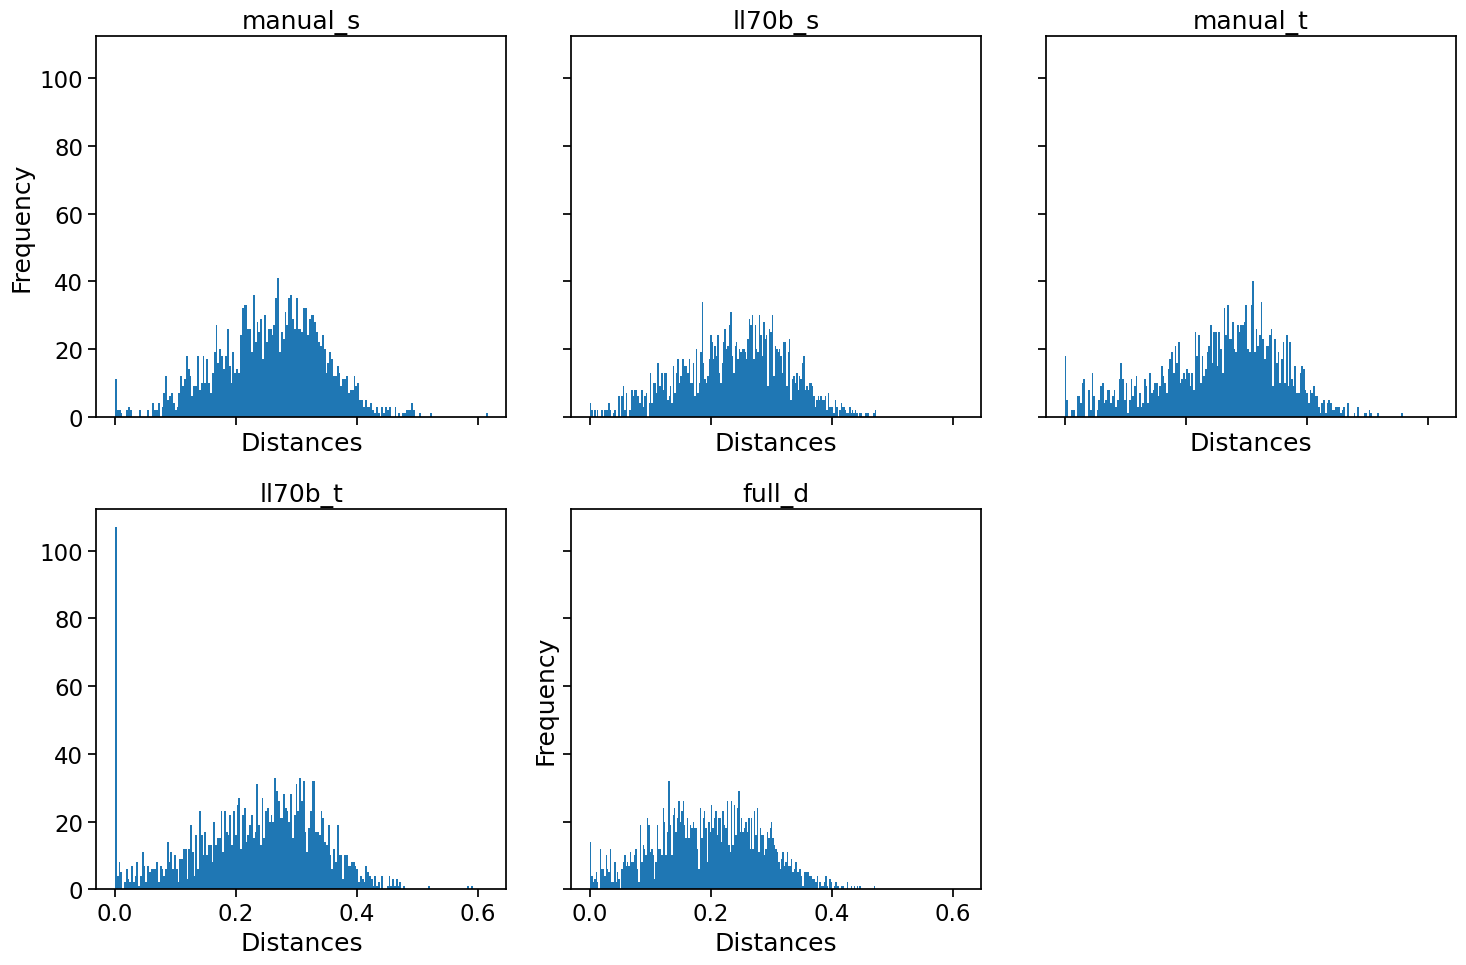

In [40]:
#@title histograms of dist from 2NN

num_embeddings = len(e_dict)
num_cols = 3
num_rows = (num_embeddings + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharey=True, sharex=True)
axes = axes.flatten()

ordered_e = ['manual_s', 'll70b_s', 'manual_t', 'll70b_t', 'full_d']
for i, emb_name in enumerate(ordered_e):
    emb=e_dict[emb_name]
    ax = axes[i]

    # Compute the distance to the 2nd nearest neighbor
    nbrs = NearestNeighbors(n_neighbors=2, metric="cosine").fit(emb)
    distances, indices = nbrs.kneighbors(emb)
    sorted_distances = np.sort(distances[:, 1])

    # Plot histogram
    ax.hist(sorted_distances, bins=200)
    ax.set_xlabel("Distances")
    if i == 0 or i==4:
      ax.set_ylabel("Frequency")
    ax.set_title(emb_name)

# Hide any empty subplots if num_embeddings is not a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("all_histograms.png")
plt.show()


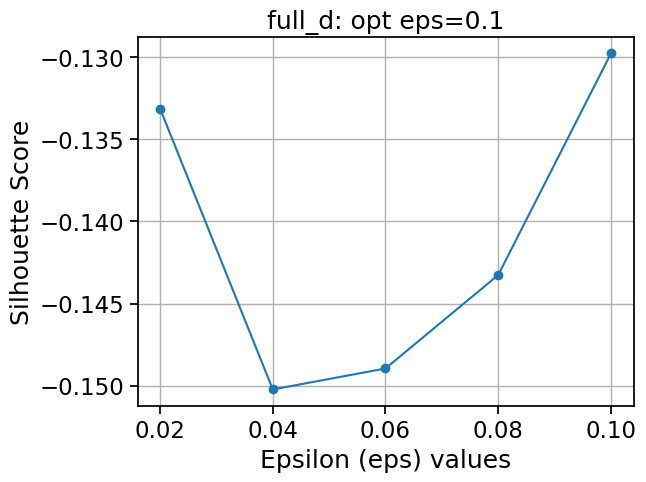

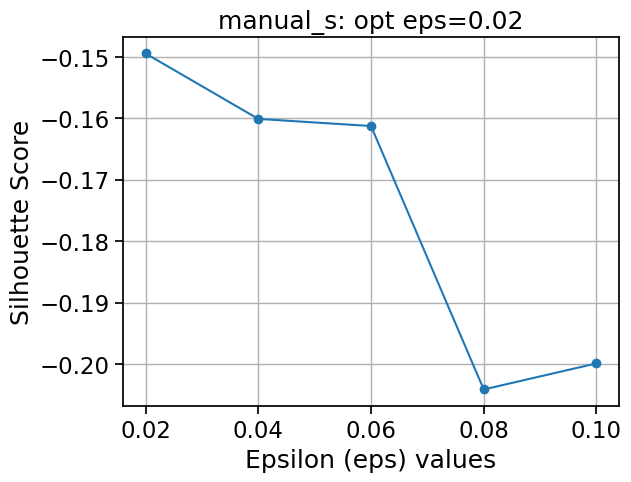

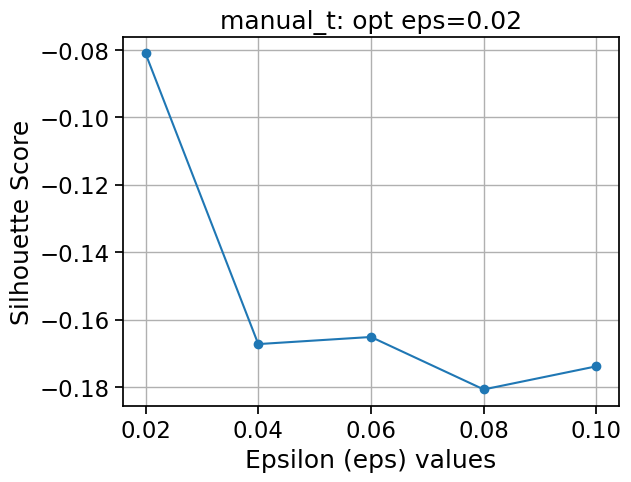

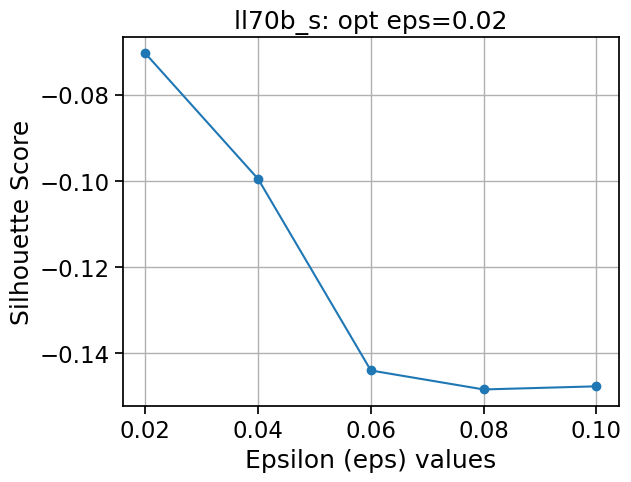

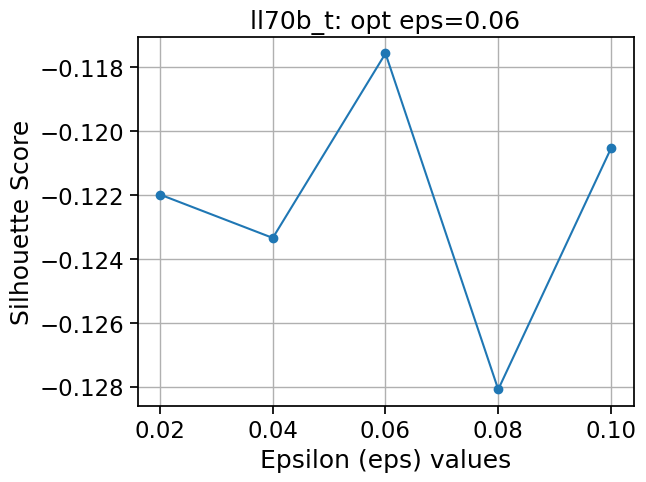

In [45]:
#@title hyperparameter tuning
# Find optimal eps param by maximizing silhouette score

opt_sils_eps = {}
# Range of eps values to test
eps_values = np.linspace(0.02, 0.1, 5)

for emb_name, emb in e_dict.items():
  silhouette_scores = []

  for eps in eps_values:
      # Run DBSCAN with the current eps value
      dbscan = DBSCAN(eps=eps, min_samples=2, metric="cosine")
      labels = dbscan.fit_predict(emb)

      # Only compute silhouette score for clusters with more than one element
      if len(set(labels)) > 1:  # Avoid -1 (noise points) or only one cluster
          score = silhouette_score(emb, labels)
      else:
          score = -1  # Assign a low silhouette score for noise or trivial clustering

      silhouette_scores.append(score)

  # Find the optimal eps with the highest silhouette score
  optimal_eps = eps_values[np.argmax(silhouette_scores)]
  opt_sils_eps[emb_name] = optimal_eps

  # Plot silhouette scores against eps values
  plt.plot(eps_values, silhouette_scores, marker='o')
  plt.xlabel('Epsilon (eps) values')
  plt.ylabel('Silhouette Score')
  plt.title(f"{emb_name}: opt eps={optimal_eps}")
  plt.grid(True)
  plt.show()



In [48]:
#@title eval
df["topics_str"] = df["topics"].apply(str)
df['hazards_str'] = df.hazards.apply(str)

print('content \t eps \t K \t avg (std) \t h@t \t h@h \t h@s \t h@d')
for emb_name, emb in e_dict.items():
  # Run DBSCAN with strict clustering
  eps = opt_sils_eps[emb_name]
  dbscan = DBSCAN(eps=eps, min_samples=2, metric="cosine")
  clusters = dbscan.fit_predict(emb)

  df[f"cluster_{emb_name}"] = clusters
  # Filter out noise points
  clustered_df = df[df[f"cluster_{emb_name}"] != -1]  # Filter out noise points
  n_clusters = clustered_df[f'cluster_{emb_name}'].nunique()
  avg_size = clustered_df[f'cluster_{emb_name}'].value_counts().mean()
  std_size = clustered_df[f'cluster_{emb_name}'].value_counts().std()
  print(f'{emb_name} \t {eps} \t {n_clusters} \t {avg_size:.2f} \t ({std_size:.2f})', end='\t')
  cols = ['topics_str', 'hazards_str', 'source_name', 'doc_type']
  for col in cols:
    # Compute homogeneity if you have ground truth source labels
    homogeneity = homogeneity_score(clustered_df[col], clustered_df[f"cluster_{emb_name}"])
    print(f"{homogeneity:.3f}", end='\t')
  print()

content 	 eps 	 K 	 avg (std) 	 h@t 	 h@h 	 h@s 	 h@d
full_d 	 0.1 	 123 	 2.63 	 (2.05)	0.821	0.801	0.944	0.798	
manual_s 	 0.02 	 7 	 2.29 	 (0.49)	0.650	0.679	1.000	1.000	
manual_t 	 0.02 	 11 	 2.64 	 (1.80)	0.771	0.779	0.905	0.961	
ll70b_s 	 0.02 	 6 	 2.00 	 (0.00)	0.728	0.915	0.829	0.657	
ll70b_t 	 0.06 	 67 	 2.97 	 (2.81)	0.781	0.736	0.909	0.751	


In [51]:
#@title analysis
# on ll70b_s content type
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

emb_name = 'll70b_s'
emb = e_dict[emb_name]
print(emb_name)
# remove non clustered data and group by cluster
clusters_df = df.loc[df[f"cluster_{emb_name}"]!=-1].groupby(f"cluster_{emb_name}")

unique_clusters = clusters_df[f"cluster_{emb_name}"].unique()
for cluster_id in unique_clusters:
    sample_cluster = cluster_id[0]
    print(f"\nData in Cluster {sample_cluster}:")
    display(df[df[f"cluster_{emb_name}"] == sample_cluster][["doc_type","topics","hazards_str", "source_name", "llama70b_summary", "llama70b_title", "english_summary", "english_title"]])

print(f'*'*5)


ll70b_s

Data in Cluster 0:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
16,Guidance,[Labelling],[],GOV.UK,"The document outlines the changes in food labelling requirements for exporting to the EU from 1 January 2021. Key points include the need for an EU or Northern Ireland address for the Food Business Operator (FBO) on pre-packaged food and caseins, restrictions on using the EU organic logo, and changes to country of origin labels. Additionally, the document provides guidance on labelling requirements for specific products such as minced meat, fruit and vegetables, olive oil, and honey blends.",Food Labelling Requirements for Exporting to the EU,"How Food and drink producers, manufactuers, retailers and suppliers muust change lables from January 1 2021",Food and drink labelling changes from 1 January 2021 - update 12 October 2020
18,Guidance,[Labelling],[],GOV.UK,"The document outlines the changes to food labelling requirements for exporting to the EU from 1 January 2021. Key changes include the need for an EU or NI address for the Food Business Operator (FBO) on pre-packaged food and caseins, the removal of the EU organic logo and emblem, and changes to country of origin labels. The guidance also provides information on labelling requirements for specific products such as minced meat, fruit and vegetables, olive oil, and honey blends.",Food Labelling Requirements for Exporting to the EU,"How food and drink producers, manufacturers, retailers, and suppliers must change labels from 1 January 2021.\nThe guidelines include subsections on Exporting to the EU, EU organic logo and emblem, EU health and identification marks, Country of origin labels and Geographical Indication (GI) logo, as well as the Goods sold in Great Britain (GB) and Northern Ireland (NI) with individual commodities details, including Minced meat, Beef and veal, Fruit and vegetables, Olive oil, Honey blends, and Eggs.",UK food and drink labelling changes from 1 January 2021



Data in Cluster 1:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
1006,Regulation,"[Contaminants, residues and contact materials, Food Safety and Security, Policies and Laws]",[],California Legislative Information,"This bill prohibits the manufacture, sale, and distribution of food products containing specified substances, including brominated vegetable oil and red dye 3, effective January 1, 2027. Violations will be punishable by civil penalties of up to $5,000 for a first offense and $10,000 for subsequent offenses.",California Food Safety Act,"Assembly Bill No. 418\nPassed the Assembly September 12, 2023\nChief Clerk of the Assembly\nPassed the Senate September 11...",AB-418 The California Food Safety Act.(2023-2024)
1007,News,"[Contaminants, residues and contact materials, Policies and Laws]",[],California Legislative Information,"This bill aims to prohibit the manufacture, sale, and distribution of food products containing specified substances, including brominated vegetable oil, red dye 3, and others, effective January 1, 2025. Violations would be punishable by civil penalties of up to $5,000 for a first violation and up to $10,000 for subsequent violations.",California Assembly Bill 418: Prohibition on Certain Substances in Food Products,"This bill, commencing January 1, 2025, would prohibit a person or entity from manufacturing, selling, delivering, distributing, holding, or offering for sale, in commerce a food product that contains any specified substance, including, among others, brominated vegetable oil and red dye. AB 418 will next move to the California Senate, where it is expected to be heard in committees in the coming weeks.\n\n",Assembly Bill No. 418 On Banning Toxic Chemicals in Foods in California



Data in Cluster 2:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
1166,News,"[Labelling, Policies and Laws]","['alcohol content', 'allergens']",WTO Documents online (Notifications),Food Standards Australia New Zealand (FSANZ) is calling for submissions on a proposal to amend the Australia New Zealand Food Standards Code to provide energy (kilojoule) labelling information on alcoholic beverages. The proposal aims to improve consumer awareness of energy content in alcoholic drinks. Submissions are invited until 6pm (Canberra time) on 27 February 2023. The proposal is part of a broader effort to improve nutrition labelling and reduce obesity and related health issues in Australia and New Zealand.,Call for Submissions: Energy Labelling on Alcoholic Beverages,Description of content: The proposal considers amending the Australia New Zealand Food Standards Code to require energy (kilojoule/kilocalorie) labelling information on packaged alcoholic beverages containing 0.5% or more ABV sold in Australia and New Zealand. Deadline Feb 27/2023,Call for submissions – Proposal P1059 Energy labelling on alcoholic beverages\n\n
1591,News,[Labelling],"['alcohol content', 'allergens']",Food Standards Australia New Zealand (FSANZ),Food Standards Australia New Zealand (FSANZ) is calling for submissions on a proposal to amend the Australia New Zealand Food Standards Code to provide energy (kilojoule) labelling information on alcoholic beverages. The proposal aims to improve consumer awareness of energy content in alcoholic drinks. Submissions are invited until 6pm (Canberra time) on 27 February 2023. The proposal is part of a broader effort to improve nutrition labelling and reduce obesity and related health issues in Australia and New Zealand.,Call for Submissions: Energy Labelling on Alcoholic Beverages,"Food Standards Australia New Zealand (FSANZ) has assessed a proposal to consider amending the Australia New Zealand Food Standards Code to provide energy (kilojoule) labelling information on alcoholic beverages and has prepared a draft food regulatory measure. Pursuant to section 61 of the Food Standards Australia New Zealand Act 1991 (FSANZ Act), FSANZ now calls for submissions to assist consideration of the draft food regulatory measure.",Energy labelling on alcoholic beverages - Call for submissions – Proposal P1059



Data in Cluster 3:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
1315,News,"[Additives, nutrition and organic foods, Food Safety and Security, Trade, market and official controls]","['cereals', 'chemical', 'coconut', 'coliforms', 'contaminant', 'cronobacter spp', 'dairy products', 'escherichia coli', 'listeria monocytogenes', 'nuts', 'pathogenic bacteria', 'salmonella', 'spoilage', 'staphylococcus', 'toxin', 'yeasts']",WTO Documents online (Notifications),"The FDA Circular updates guidelines for assessing microbiological quality of processed food products, repealing FDA Circular No. 2013-010. The guidelines cover food establishments in the Philippines, providing definitions of terms, and outlining objectives, scope, and general and specific guidelines for ensuring food safety and compliance with Good Manufacturing Practices (GMP). The guidelines reference internationally recognized standards and methods for microbiological analysis.",Updated Guidelines for the Assessment of Microbiological Quality of Processed Food Products,Repealing Philippines FDA Circular No. 2013-010. The draft Circular aims to provide updated guidelines for the assessment of microbiological quality of certain processed food products and help ensure that food manufacturers comply with Good Manufacturing Practices (GMP).,Draft Updated Guidelines for the Assessment of Microbiological Quality of Processed Food Products
1398,News,"[Contaminants, residues and contact materials, Food Safety and Security, Policies and Laws]","['cereals', 'chemical', 'coconut', 'coliforms', 'contaminant', 'cronobacter spp', 'dairy products', 'escherichia coli', 'listeria monocytogenes', 'nuts', 'pathogenic bacteria', 'salmonella', 'spoilage', 'staphylococcus', 'toxin', 'yeasts']",Food and Drug Administration Philippines,"The FDA Circular updates the guidelines for assessing the microbiological quality of processed food products in the Philippines, repealing FDA Circular No. 2013-010. The guidelines cover food establishments engaged in the manufacture, trade, and distribution of processed food products, and provide definitions of terms, objectives, and scope. The guidelines aim to ensure food safety and compliance with Good Manufacturing Practices (GMP) by providing reference criteria for specific food commodities and internationally recognized references for microbiological analysis.",Updated Guidelines for the Assessment of Microbiological Quality of Processed Food Products,"The Philippine Food and Drugs Administration issued the draft for the ""Updated Guidelines for the Assessment of Microbiological Quality of Processed Food Products Repealing FDA Circular No. 2013-010 “Revised Guidelines for the Assessment of Microbiological Quality of Processed Foods” for public comments. The reference criteria for specific food commodities as stated in Tables 1 to 15 now includes pre-packaged tubed and cubed ice, ethnic milk-based confectioneries, and food supplements. Also specified in the draft that the methods used for the enumeration or detection of specified microorganisms shall be those that have been internationally established such as FDA BAM, ICMSF, Codex Alimentarius Commission Guidelines, etc. All comments shall be made on or before 26 June 2021",Draft for Comments of the Updated Philippine Guidelines for the Assessment of Microbiological Quality of Processed Food Products Repealing FDA Circular No. 2013-010 “Revised Guidelines for the Assessment of Microbiological Quality of Processed Foods”



Data in Cluster 4:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
1529,News,[Labelling],[],TURKEY MINISTRY OF AGRICULTURE AND FORESTRY,"This document outlines amendments to the Turkish Food Codex Regulation on Food Labeling and Consumer Information, focusing on labeling requirements for food products. Key changes include specifications for font sizes, placement of information on labels, and prohibitions on misleading expressions. The amendments aim to ensure accurate and clear labeling, protecting consumers from confusion. Food business operators must comply with these changes by December 31, 2023.",Amendments to Turkish Food Codex Regulation on Food Labeling and Consumer Information,"The Ministry of Agriculture and Forestry published a draft amendment to Turkey's Food Codex Regulation stating that any expressions, names and images that can mislead the cosumers are not allowed to be used on food labels. The requirements for location of some elements of the label , e.g. product name, brand, as well as the requirements for font size of the labelling mandatory information are also specifiied.",Draft amendment to Turkey's Food Codex Regulation
2080,Guidance,[Labelling],[],"T.C. GIDA TARIM VE HAYVANCILIK BAKANLIĞI - REPUBLIC OF TURKEY MINISTRY OF FOOD, AGRICULTURE AND LIVESTOCK","This document outlines amendments to the Turkish Food Codex Regulation on Food Labeling and Consumer Information, focusing on labeling requirements for food products. Key changes include specifications for font sizes, placement of information on labels, and prohibitions on misleading expressions. The amendments aim to improve consumer information and prevent confusion. Food business operators must comply with the new provisions by December 31, 2023.",Amendments to Turkish Food Codex Regulation on Food Labeling and Consumer Information,"On the surface area where the brand is written, some statements permitted for descriptive name and the formatting provisions Enter in force April 1/2022",Draft Amending the Turkish Food Labeling and Consumer Information Regulation



Data in Cluster 5:


,doc_type,topics,hazards_str,source_name,llama70b_summary,llama70b_title,english_summary,english_title
2035,Guidance,"[Additives, nutrition and organic foods, Policies and Laws]","['chlorine', 'escherichia coli', 'nitrogen', 'sulphur dioxide']",Singapore Food Agency (former Agri-Food & Veterinary Authority of Singapore),"This guidance document outlines the food additives permitted for use in food products imported or manufactured for sale in Singapore, as specified under the Food Regulations. It provides a list of permitted food additives with their corresponding INS numbers, names, and regulations, and advises food businesses to refer to the specific regulations for maximum levels of use and other details.",Food Additives Permitted Under the Singapore Food Regulations,"Food additives permitted for use in food products imported/manufactured for sale in Singapore are specified under the Food Regulations. The Singapore Food Agency (SFA) has prepared this guidance document to assist food businesses to conduct self-checks on their food products to ensure that only permitted food additives are used, and the levels used are within the maximum levels permitted under the Food Regulations.",Food Additives Permitted under the Singapore Food Regulations
2038,Regulation,"[Additives, nutrition and organic foods]","['chemical', 'chlorine', 'escherichia coli', 'nitrogen', 'sulphur dioxide']",Singapore Food Agency (former Agri-Food & Veterinary Authority of Singapore),"This guidance document outlines the food additives permitted for use in food products imported or manufactured for sale in Singapore, as specified under the Food Regulations. It provides a list of permitted food additives with their corresponding INS numbers, names, and regulations, and advises food businesses to refer to the specific regulations for maximum levels of use and other details.",Food Additives Permitted Under the Singapore Food Regulations,"The Singapore Food Agency (SFA) has prepared this guidance document to assist food businesses to conduct self -checks on their food products to ensure that only permitted food additives are used, and the levels used are within the maximum levels permitted under the Food Regulations. This guidance document is not legally binding, and should be read together with the Food Regulations.",Singapore guidance document on food additive permitted under Food Regulations (as at 30 June 2021)


*****


In [ ]:
df.drop(columns=['topics_str', 'hazards_str', 'cluster_full_d',
                 'cluster_manual_s', 'cluster_manual_t', 'cluster_ll70b_t'], inplace=True)

# save cluster_ll70b_s column
df.to_csv('fss_clean_data.csv', index=False)

# Exploratory Analysis

In [ ]:
#@title load data
print ('Upload the `fss_clean_data.csv` file: ')
files.upload()
df = pd.read_csv('fss_clean_data.csv')

## Data Statistics

###Topics analysis

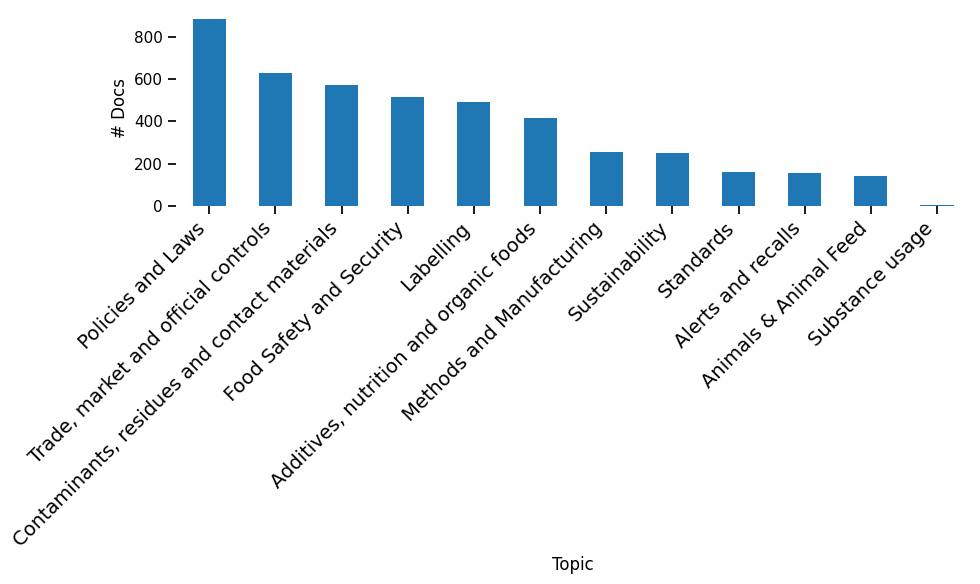

In [60]:
#@title topic distr
topic_columns = sorted(set([topic for sublist in df['topics'] for topic in sublist]))
# sns.set_context("notebook", font_scale=1)
# Plot topic distribution
plt.figure(figsize=(10,6))
df[topic_columns].sum().sort_values(ascending=False).plot(kind="bar")
sns.despine(left='True', bottom='True')

plt.xticks(rotation=45, ha="right", fontsize=14)
plt.ylabel("# Docs")
plt.xlabel("Topic")
plt.tight_layout()
plt.savefig("topics_distr.pdf", dpi=300, format='PDF')
plt.show()


In [56]:
# Count the number of documents per doc type and topic
doc_topic_counts = df.groupby("doc_type")[topic_columns].sum()
doc_topic_counts

,"Additives, nutrition and organic foods",Alerts and recalls,Animals & Animal Feed,"Contaminants, residues and contact materials",Food Safety and Security,Labelling,Methods and Manufacturing,Policies and Laws,Standards,Substance usage,Sustainability,"Trade, market and official controls"
doc_type,,,,,,,,,,,,
Guidance,42,6,28,51,57,72,34,119,40,0,38,133
News,239,145,81,360,323,304,153,528,83,1,167,397
Regulation,104,0,23,97,52,96,54,224,34,0,23,93
Scientific,33,4,10,63,84,18,15,14,1,0,23,6


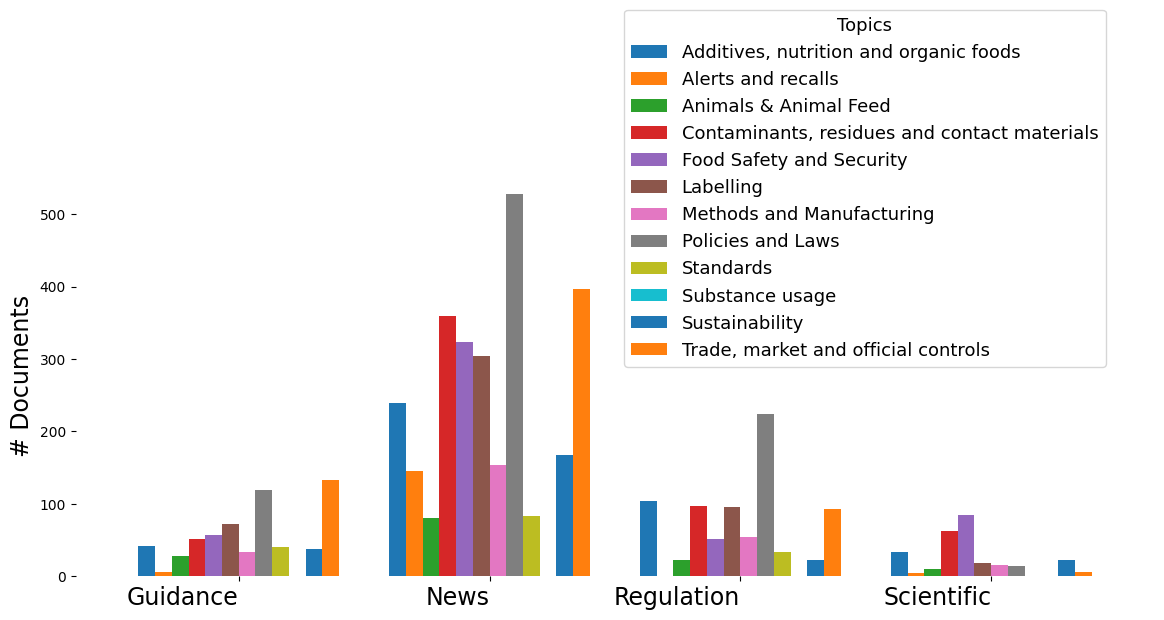

In [ ]:
#@title doc_type-wise topic distr
doc_type_topic_counts = df.groupby("doc_type")[topic_columns].sum()

# Plot each source_type on the x-axis, and bars for each topic for each doc_type
doc_type_topic_counts.plot(kind="bar", stacked=False, figsize=(12, 6), width=0.8)
sns.despine(left='True', bottom='True')
plt.xlabel("")
plt.ylabel("# Documents", fontsize=17)
plt.xticks(rotation=0, ha="right", fontsize=17)
plt.legend(title="Topics", title_fontsize=13, fontsize=13, bbox_to_anchor=(0.5, 0.5))
plt.tight_layout()

plt.savefig("doc_type_topics_distr.png", dpi=300)
plt.show()


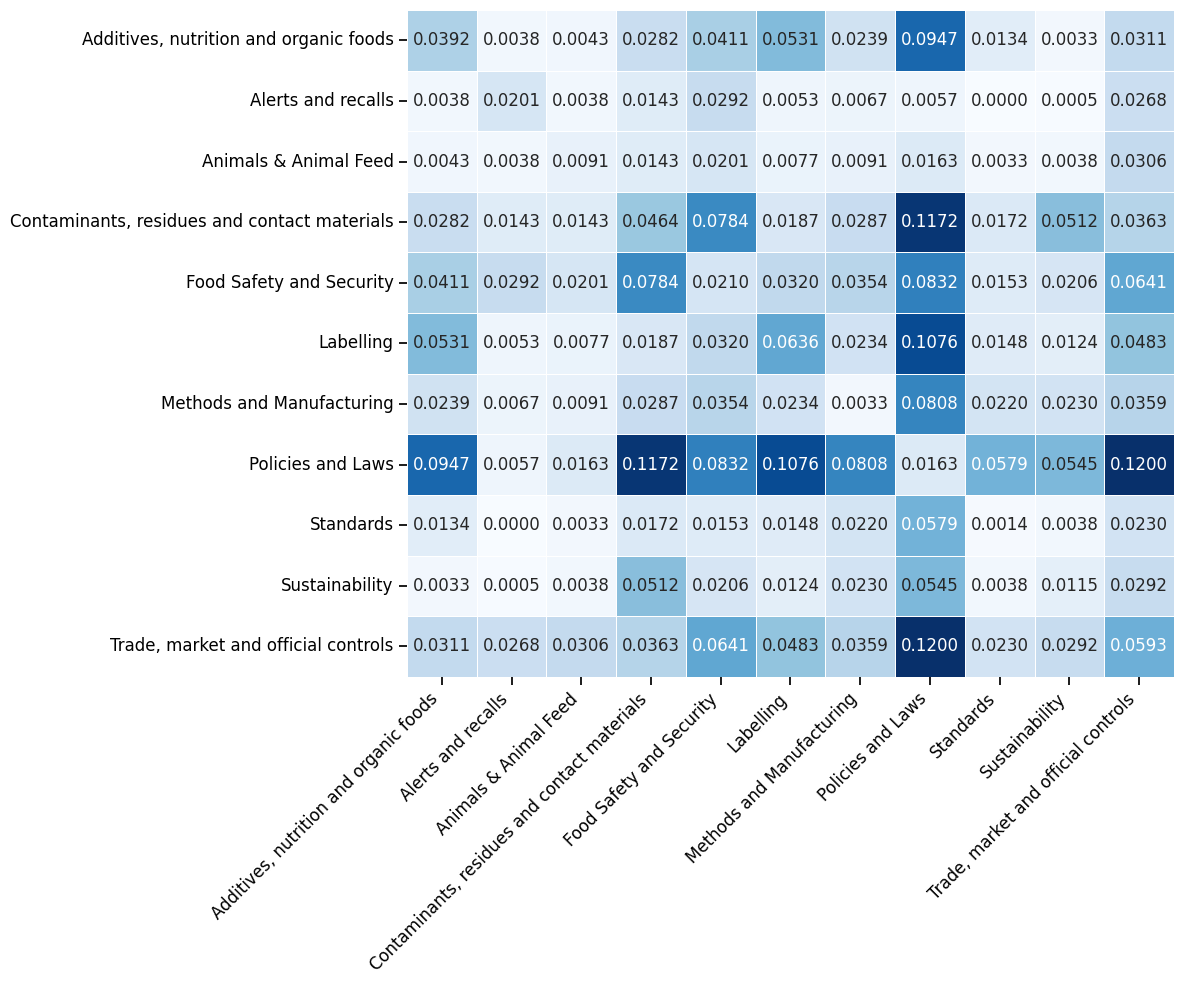

In [58]:
#@title topic co-occurence
from itertools import combinations

sns.set_context("notebook", font_scale=1)

# Flatten the list of all topics and convert to a sorted list
all_topics = sorted(set([topic for sublist in df['topics'] for topic in sublist]))

# Initialize the co-occurrence matrix with a DataFrame of zeros
co_occurrence_matrix = pd.DataFrame(0, index=all_topics, columns=all_topics)

# Populate the matrix with co-occurrence counts
for topic_list in df['topics']:
    if len(topic_list) == 1:
        # If only one topic appears in the document, increment the diagonal count
        single_topic = topic_list[0]
        co_occurrence_matrix.loc[single_topic, single_topic] += 1
    else:
        # Count co-occurrences for multiple topics
        for t1, t2 in combinations(topic_list, 2):
            co_occurrence_matrix.loc[t1, t2] += 1
            co_occurrence_matrix.loc[t2, t1] += 1  # Ensure symmetry

# Normalize the co-occurrence matrix by the total number of documents
total_documents = len(df)
co_occurrence_matrix = co_occurrence_matrix / total_documents
co_occurrence_matrix = co_occurrence_matrix.drop(index='Substance usage', columns='Substance usage', errors='ignore')

# Plot the normalized co-occurrence matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, cmap="Blues", annot=True, fmt=".4f", linewidths=0.5, cbar=False)
plt.xticks(rotation=45, ha='right',fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

plt.savefig("topic_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


### Hazards analysis

In [38]:
from ast import literal_eval as le

# Explode to have one hazard per row
df_exploded = df.explode('hazards')
# Count occurrences per type and hazard
hazard_counts = df_exploded.groupby(['doc_type', 'hazards']).size().reset_index(name='count')

hazard_doc_type_df = hazard_counts.pivot_table(index='hazards', columns='doc_type', values='count', fill_value=0)
hazard_doc_type_df.corr()

doc_type,Guidance,News,Regulation,Scientific
doc_type,,,,
Guidance,1.000000,0.967340,0.967167,0.952800
News,0.967340,1.000000,0.953598,0.946082
Regulation,0.967167,0.953598,1.000000,0.962157
Scientific,0.952800,0.946082,0.962157,1.000000


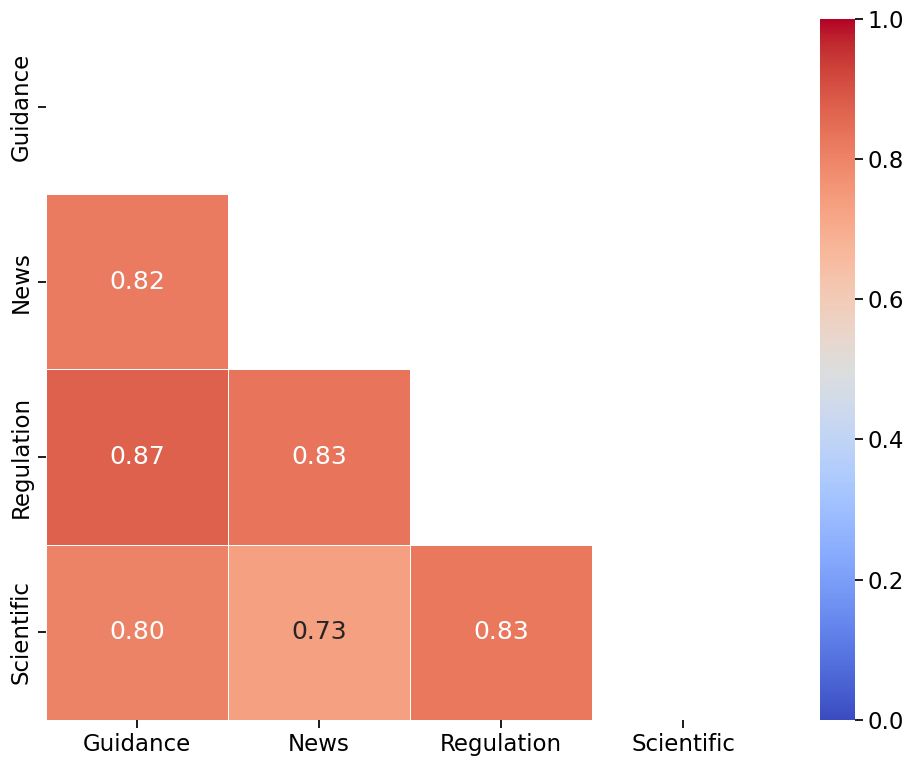

In [39]:
#@title heatmap

# Calculate the correlation matrix
correlation_matrix = hazard_doc_type_df.corr(method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set_context("notebook", font_scale=1.5)  # Adjust 'font_scale' as needed

# Create the heatmap with the mask and setting zero values to blue
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, mask=mask, vmin=0, vmax=1, annot_kws={"size": 18}  )
plt.xlabel(''); plt.ylabel('');
plt.tight_layout()
plt.savefig("correlation_matrix_source_hazards.pdf", dpi=300, format='PDF')
plt.show()

## Text Statistics

### Doc Length

In [52]:
#@title doc length stats
df["doc_length"] = df["cleaned_html"].str.split().str.len()
df["english_summary_length"] = df["english_summary"].str.split().str.len()
df["llama70b_summary_length"] = df["llama70b_summary"].str.split().str.len()
df["english_title_length"] = df["english_title"].str.split().str.len()
df["llama70b_title_length"] = df["llama70b_title"].str.split().str.len()

print("\n Full-D word counts stats:")
print(df["doc_length"].describe())

print("\n Manual-S word counts stats:")
print(df["english_summary_length"].describe())

print("\n Ll70b-S word counts stats:")
print(df["llama70b_summary_length"].describe())

print("\n Manual-T word counts stats:")
print(df["english_title_length"].describe())

print("\n Ll70b-T word counts stats:")
print(df["llama70b_title_length"].describe())


 Full-D word counts stats:
count      2091.000000
mean       6448.091344
std       20009.055331
min          45.000000
25%         514.000000
50%        1140.000000
75%        4367.500000
max      474027.000000
Name: doc_length, dtype: float64

 Manual-S word counts stats:
count    2091.000000
mean       85.527021
std        60.177350
min         5.000000
25%        41.000000
50%        71.000000
75%       112.000000
max       450.000000
Name: english_summary_length, dtype: float64

 Ll70b-S word counts stats:
count    2091.000000
mean       72.890483
std        16.209188
min        29.000000
25%        62.000000
50%        73.000000
75%        83.000000
max       261.000000
Name: llama70b_summary_length, dtype: float64

 Manual-T word counts stats:
count    2091.000000
mean       13.823051
std         7.275131
min         1.000000
25%         9.000000
50%        12.000000
75%        17.000000
max        59.000000
Name: english_title_length, dtype: float64

 Ll70b-T word counts stats:

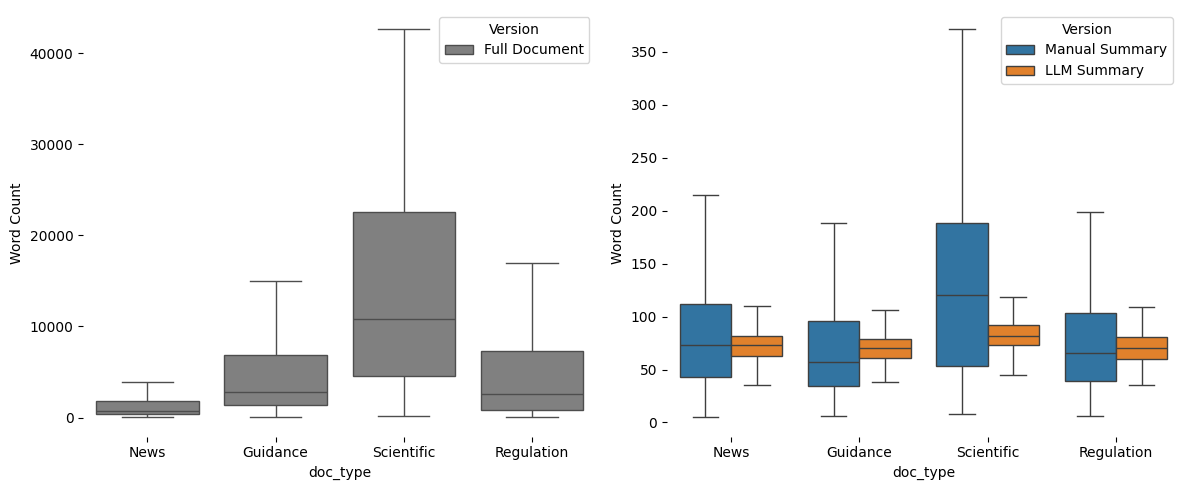

In [ ]:
#@title boxplots
# Melt the dataframe for easy plotting
df_melted = df.melt(id_vars=["doc_type"],
                     value_vars=["doc_length", "english_summary_length", "llama70b_summary_length"],
                     var_name="Version",
                     value_name="Length")

# Rename
df_melted["Version"] = df_melted["Version"].replace({
    "doc_length": "Full Document",
    "english_summary_length": "Manual Summary",
    "llama70b_summary_length": "LLM Summary"
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Full Document Boxplot
sns.boxplot(data=df_melted[df_melted["Version"] == "Full Document"],
            x="doc_type", y="Length", ax=axes[0], color="gray", showfliers=False)
axes[0].set_ylabel("Word Count")
axes[0].legend(["Full Document"], loc="upper right", title='Version')
# Summary Boxplots
sns.boxplot(data=df_melted[df_melted["Version"] != "Full Document"],
            x="doc_type", y="Length", hue="Version", ax=axes[1], showfliers=False)
axes[1].set_ylabel("Word Count")

sns.despine(left='True', bottom='True')

plt.tight_layout()
plt.savefig("doc_type_len_boxplots.png", dpi=300)
plt.show()

### Vocab

In [54]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
import string

# clean and tokenize text
def get_vocabulary_size(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS and word not in string.punctuation]
    return len(set(tokens))

# Apply the function to each column
df['vocab_full_doc'] = df['cleaned_html'].apply(get_vocabulary_size)
df['vocab_manual_title'] = df['english_title'].apply(get_vocabulary_size)
df['vocab_manual_summary'] = df['english_summary'].apply(get_vocabulary_size)
df['vocab_llama70b_summary'] = df['llama70b_summary'].apply(get_vocabulary_size)
df['vocab_llama70b_title'] = df['llama70b_title'].apply(get_vocabulary_size)

# Print the vocabulary sizes for each document version
vocab_sizes = df[['vocab_full_doc', 'vocab_manual_title', 'vocab_manual_summary',
                  'vocab_llama70b_summary', 'vocab_llama70b_title']]

In [ ]:
#@title vocab stats
vocab_stats = vocab_sizes.agg(["mean", "std"])
print(vocab_stats.round(2))


      vocab_full_doc  vocab_manual_title  vocab_manual_summary  \
mean          826.97                9.71                 41.81   
std          1410.14                4.33                 25.09   

      vocab_llama70b_summary  vocab_llama70b_title  
mean                   39.50                  7.60  
std                     7.95                  2.16  


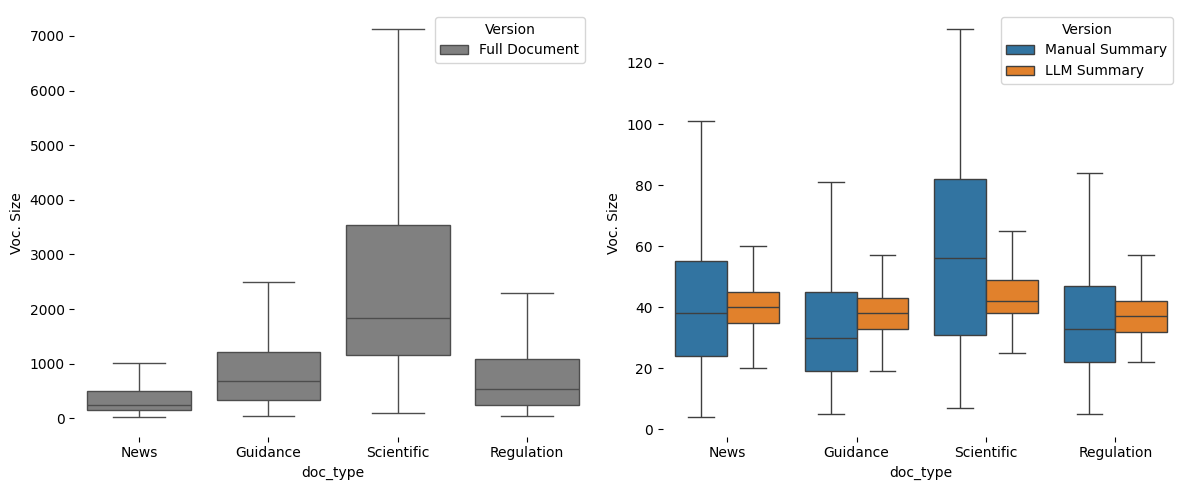

In [ ]:
#@title boxplots
# Melt the dataframe for easy plotting
df_melted = df.melt(id_vars=["doc_type"],
                     value_vars=["vocab_full_doc", "vocab_manual_summary", "vocab_llama70b_summary"],
                     var_name="Version",
                     value_name="Length")

# Rename for clarity
df_melted["Version"] = df_melted["Version"].replace({
    "vocab_full_doc": "Full Document",
    "vocab_manual_summary": "Manual Summary",
    "vocab_llama70b_summary": "LLM Summary"
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Full Document Boxplot
sns.boxplot(data=df_melted[df_melted["Version"] == "Full Document"],
            x="doc_type", y="Length", ax=axes[0], color="gray", showfliers=False)
axes[0].set_ylabel("Voc. Size")
axes[0].legend(["Full Document"], loc="upper right", title='Version')
# Summary Boxplots
sns.boxplot(data=df_melted[df_melted["Version"] != "Full Document"],
            x="doc_type", y="Length", hue="Version", ax=axes[1], showfliers=False)
axes[1].set_ylabel("Voc. Size")

sns.despine(left='True', bottom='True')

plt.tight_layout()
plt.savefig("doc_type_voc_size_boxplots.png", dpi=300)
plt.show()


# Dataset to share

In [ ]:
#@title load data
print ('Upload the `fss_clean_data.csv` file: ')
files.upload()
df = pd.read_csv('fss_clean_data.csv')

In [66]:
df.columns

Index(['english_summary', 'english_title', 'source_name', 'topics',
       'cleaned_html', 'llama70b_title', 'llama70b_summary', 'doc_type',
       'Additives, nutrition and organic foods', 'Alerts and recalls',
       'Animals & Animal Feed', 'Contaminants, residues and contact materials',
       'Food Safety and Security', 'Labelling', 'Methods and Manufacturing',
       'Policies and Laws', 'Standards', 'Substance usage', 'Sustainability',
       'Trade, market and official controls', 'hazards', 'cluster_ll70b_s'],
      dtype='object')

In [69]:
#@title drop and rename cols
#drop cols per topics
topic_columns = sorted(set([topic for sublist in df['topics'] for topic in sublist]))
df.drop(columns=topic_columns, inplace=True)

# drop original data
df.drop(columns=['cleaned_html'], inplace=True)

# rename english summary and title to manual
df.rename(columns={'english_summary': 'manual_summary', 'english_title': 'manual_title'}, inplace=True)

df.to_csv('fss_shared.csv', index=False)

In [72]:
df.sample()

,manual_summary,manual_title,source_name,topics,llama70b_title,llama70b_summary,doc_type,hazards,cluster_ll70b_s
945,"The general labelling obligation for surface treatment agents for fruit and vegetables in Germany was published without taking into account objections from the trade associations.\nThe main issue is the indication ""waxed"" on fruit and vegetables. Until now, this information was only required in Germany for fresh citrus fruits, melons, apples and pears if one of the following additives was used: E 901 to E 904, E 912 and E914.\nFrom now on, the labelling obligation applies to all fresh fruit and vegetables and also to so-called coating agents with the additive codes E 445, E 471, E 473, E 474. The labelling must be indicated visibly for consumers on loose goods as well as on pre-packaged products. The EU is now under pressure to adopt a uniform European labelling regulation as soon as possible.\n\n","Ordinance on the reorganization of food law regulations on food additives, From 2 June 2021",German Official Gazette Publisher,"[Additives, nutrition and organic foods, Labelling]",Ordinance on the Implementation of Union Provisions on Food Additives (LMZDV),"This ordinance implements Union provisions on food additives, regulating their use, labeling, and production in Germany. It applies to food additives as defined in EU Regulation 1333/2008 and covers their use in food production, labeling requirements, and the production of nitrite curing salt. The ordinance also defines non-prepackaged foodstuffs and regulates their labeling and supply to final consumers or mass caterers.",Regulation,[nitrogen],-1
